<a href="https://colab.research.google.com/github/architect-code/ST463/blob/main/ST463_Stochastic_Simulation%2C_Training_and_Calibration%2C_Seminar_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some general remarks about the code below:



*   As you can see, the code is readable by humans (and not just by the Python interpreter): in general, you have to choose informative function and variable names and use consistent formatting. For instance, you can check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
*   There are some **food for thought**, denoted with $\clubsuit$-$\star$, where $\star$ denote the number of the **food for thought**: you can submit these exercises to me. Their submission is voluntary, but I will be happy to provide you with detailed feedbacks. If you decide to submit these exercises please create a new .ipynb file named "ST463 - Seminar II - "YOUR NAME" - "YOUR SURNAME"".
* For each part of the **food for thought** a solution box has been added, but you may insert additional boxes. Do not hesitate to add Text boxes for textual answers (via `+Text`). But make sure to replace any part that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove the `raise NotImplementedError()`.

In this seminar, we will study a problems linked to the concept of **random simulation** arising in finance and risk-management, namely, we will see how to model extreme stock market events with a Gaussian copula.

# Modelling extreme stock market events with copulas.




## Theorethical background.

We first introduce the concept of **Copulas**.

In a sense, every joint distribution function for a random vector of risk factors implicitly contains both a description of the marginal behaviour of individual risk factors and a description of their dependence structure; the **copula** approach provides a way of isolating the description of the **dependence structure**. It is of course only one way of treating dependence in multivariate risk models and is perhaps most natural in a static distributional context rather than a dynamic time series one.

Copulas express dependence on a **quantile scale**, which is useful for describing the dependence of extreme outcomes and is natural in a risk-management context, where **VaR** has led us to think of risk in terms of quantiles of loss distributions.

Moreover, copulas facilitate a **bottom-up approach to multivariate model building**. This is particularly useful in risk management, where we very often have a much better idea about the marginal behaviour of individual risk factors than we do about their dependence structure. An example is furnished by credit risk, where the individual default risk of an obligor, while in itself difficult to estimate, is at least something we can get a better handle on than the dependence among default risks for several obligors. The copula approach in general allows to combine marginal models with a variety of possible dependence models and to investigate the sensitivity of risk to the dependence specification. Copulas are easily to simulate and they lend themselves in particular to Monte Carlo studies of risk.

**Definition** A $d$-dimensional copula is a distribution function on $[0,1]^d$ with standard uniform marginal distributions.

We reserve the notation $C(\mathbf{u}) = C(u_1,\ldots,u_d)$ for the multivariate dfs that are copulas. Hence $C$ is a mapping of the form $C:[0, 1]^d→[0, 1]$, i.e., a mapping of the unit hypercube into the unit interval. The following three properties must hold.



1.   $C(u_1,\ldots,u_d)$ is increasing in each component $u_i$.
2.   $C(1,\ldots,1,u_i,1,\ldots,1)=u_i$ for all $i \in \{1,\ldots,d\}$, $u_i \in [0,1]$.
3.   For all $(a_1,\ldots,a_d), (b_1,\ldots,b_d) \in [0,1]^d$ with $a_i \leq b_i$ we have
\begin{equation*}
\sum_{i_1=1}^2\ldots\sum_{i_d=1}^2 (-1)^{i_1+\ldots+i_d} C(u_{1 i_1},\ldots, u_{d i_d}) \geq 0,
\end{equation*}
where $u_{j 1} = a_j$ and $u_{j 2} = b_j$ for all $j\in \{1,\ldots,d\}$.

The first property is clearly required of any multivariate df and the second property is the requirement of uniform marginal distributions. The third property is less obvious, but the so-called rectangle inequality in 3. ensures that if the random vector $(U_1,\ldots,U_d)$ has df $C$, then $\mathbb{P}(a_1 \leq U_1 \leq b_1,\ldots, a_d \leq U_d \leq b_d)$ is
non-negative. These three properties characterize a copula; if a function $C$ fulfills them, then it is a copula.

The importance of copulas in the study of multivariate distribution functions is summarized by the following elegant theorem, which shows, firstly,
that all multivariate dfs contain copulas and, secondly, that copulas may be used in conjunction with univariate dfs to construct multivariate dfs.

**Theorem 5.3 (Sklar 1959)** Let $F$ be a joint distribution function with margins $F_1,\ldots, F_d$. Then there exists a copula $C:[0,1]^d → [0,1]$ such that, for all $x_1,\ldots, x_d$ in $\mathbb{R} = [−∞,∞]$,
\begin{equation}
    F(x_1,\ldots,x_d ) = C(F_1(x_1),\ldots, F_d(x_d))\quad (\star)
\end{equation}
If the margins are continuous, then $C$ is unique. Conversely, if $C$ is a copula and $F_1,\ldots, F_d$ are univariate distribution functions, then the function $F$ defined in $(\star)$ is a joint distribution function with margins
$F_1, \ldots, F_d$.

In particular, if we evaluate $(\star)$ at the arguments $x_i = F^{-1}(u_i)$, $0 \leq u_i \leq 1$, $i=1, \ldots, d$, we obtain
\begin{equation}
    C(u_1,\ldots,u_d ) = F(F_1^{-1}(u_1),\ldots, F_d^{-1}(u_d)),
\end{equation}
which gives an explicit representation of $C$ in terms of $F$ and its margins.

In the present seminar, we study the so-called bi-variate Gaussian copula, which is defined as:
\begin{equation}
C_{\rho}^{\text{Ga}}(u_1, u_2) = \int_{-\infty}^{\Phi^{-1}(u_1)}\int_{-\infty}^{\Phi^{-1}(u_2)}\frac{1}{2\pi(1-\rho^2)^{1/2}}\exp\left\{-\frac{(s_1^2-2 \rho s_1 s_2 + s_2^2)}{2(1-\rho^2)}\right\}ds_1 ds_2
\end{equation}

## Implementation.


First, we build an hypothetical portfolio consisting of three major tech stocks and retrieve the data from **yfinance**.

More precisely, we will download the historical stock price data for Microsoft (ticker symbol: MSFT), Apple (ticker symbol: AAPL), and Google (ticker symbol: GOOGL) from January 1, 2020, to January 1, 2022.   

In [ ]:
import yfinance as yf

portfolio_tickers = ["MSFT", "AAPL", "GOOGL"]
end_date = "2022-01-01"
start_date = "2020-01-01"
symbols = ["^GSPC"] + portfolio_tickers
## Nota: GSPC stands for Global Standard & Poor's Composite.
data = yf.download(symbols, start=start_date, end=end_date)["Adj Close"]

## Compute daily returns
returns = data.pct_change().dropna()

[*********************100%%**********************]  4 of 4 completed


The second step is to ensure that the data is suitable for copula analysis; it needs to lie within a [0,1] range. We apply the quantile transformation, which essentially ranks the data in a uniform distribution.

In [ ]:
import pandas as pd
from sklearn.preprocessing import QuantileTransformer

quantile_transformers = {}
data_uniform = pd.DataFrame()

for symbol in returns.columns:
    """Transform returns to 0-1 range using quantile transformation."""
    qt = QuantileTransformer(output_distribution='uniform')
    ## It applies a non-linear transformation such that the probability density
    ## function of each feature will be mapped to a uniform or Gaussian
    ## distribution. In this case, all the data, including outliers, will be
    ## mapped to a uniform distribution with the range [0, 1], making outliers
    ## indistinguishable from inliers.
    data_uniform[symbol] = qt.fit_transform(returns[[symbol]]).flatten()
    quantile_transformers[symbol] = qt

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (504). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (504). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (504). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (504). n_quantiles is set to n_samples.
  warnings.warn(


Our primary interest is to understand how a certain drop in the S$\&$P 500 would affect our portfolio stocks. Therefore, we need to establish a joint behaviour between the S$\&$P 500 and each stock. This relationship is captured using a **bivariate Gaussian copula**.

Using the copula, a conditional distribution is derived, which tells us about the potential behavior of our stocks' returns, given a certain drop in the S$\&$P 500.

Notice that if $U_1 = \Phi(X_1)$ and $U_2 = \Phi(X_2)$ with $\Phi$ the c.d.f. of a standard normal distribution, then both $U_1$ and $U_2$ are uniformly distributed and
\begin{equation}
\mathbb{P}(U_2 \leq v | U_1 = u) = \Phi\left(\frac{\Phi^{-1}(v)-\rho \Phi^{-1}(u)}{\sqrt{1-\rho^2}}\right)
\end{equation}

In [ ]:
import numpy as np
from scipy.stats import norm

def conditional_sample(u1, rho, n_samples=1000):
    """Define the function for conditional sampling."""
    u2 = np.linspace(0.001, 0.999, n_samples)
    return u2, norm.cdf((norm.ppf(u1) - rho * norm.ppf(u2)) / np.sqrt(1 - rho**2))


For each of the portfolio’s stocks, given the drop in the S$\&$P 500 (specified as a percentage), the copula model is used to simulate potential stock returns. These simulated returns provide insights into probable worst-case, best-case, and mean scenarios for each stock.

In [ ]:
pip install -U copulae

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 13.5 MB/s eta 0:00:00


In [ ]:
from copulae import GaussianCopula
market_drop_percentage = -0.05

results = {}
for ticker in portfolio_tickers:
    """Simulation for each stock in the portfolio"""
    index_drop = quantile_transformers["^GSPC"].transform(np.array([[market_drop_percentage]]))[0][0]

    # Bivariate assumption with ^GSPC and each stock
    bi_data = data_uniform[["^GSPC", ticker]]
    bi_copula = GaussianCopula(dim=2)
    bi_copula.fit(bi_data.values)
    rho = bi_copula.params[0]

    conditional_u2, conditional_cdf = conditional_sample(index_drop, rho)
    conditional_returns = quantile_transformers[ticker].inverse_transform(conditional_cdf.reshape(-1, 1)).flatten()
    results[ticker] = conditional_returns

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have 

Visualization for each stock in the portfolio; impact to each stock in portfolio.

<ipython-input-6-bee365d4d98b>:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(conditional_returns, shade=True, ax=ax[1, 0])


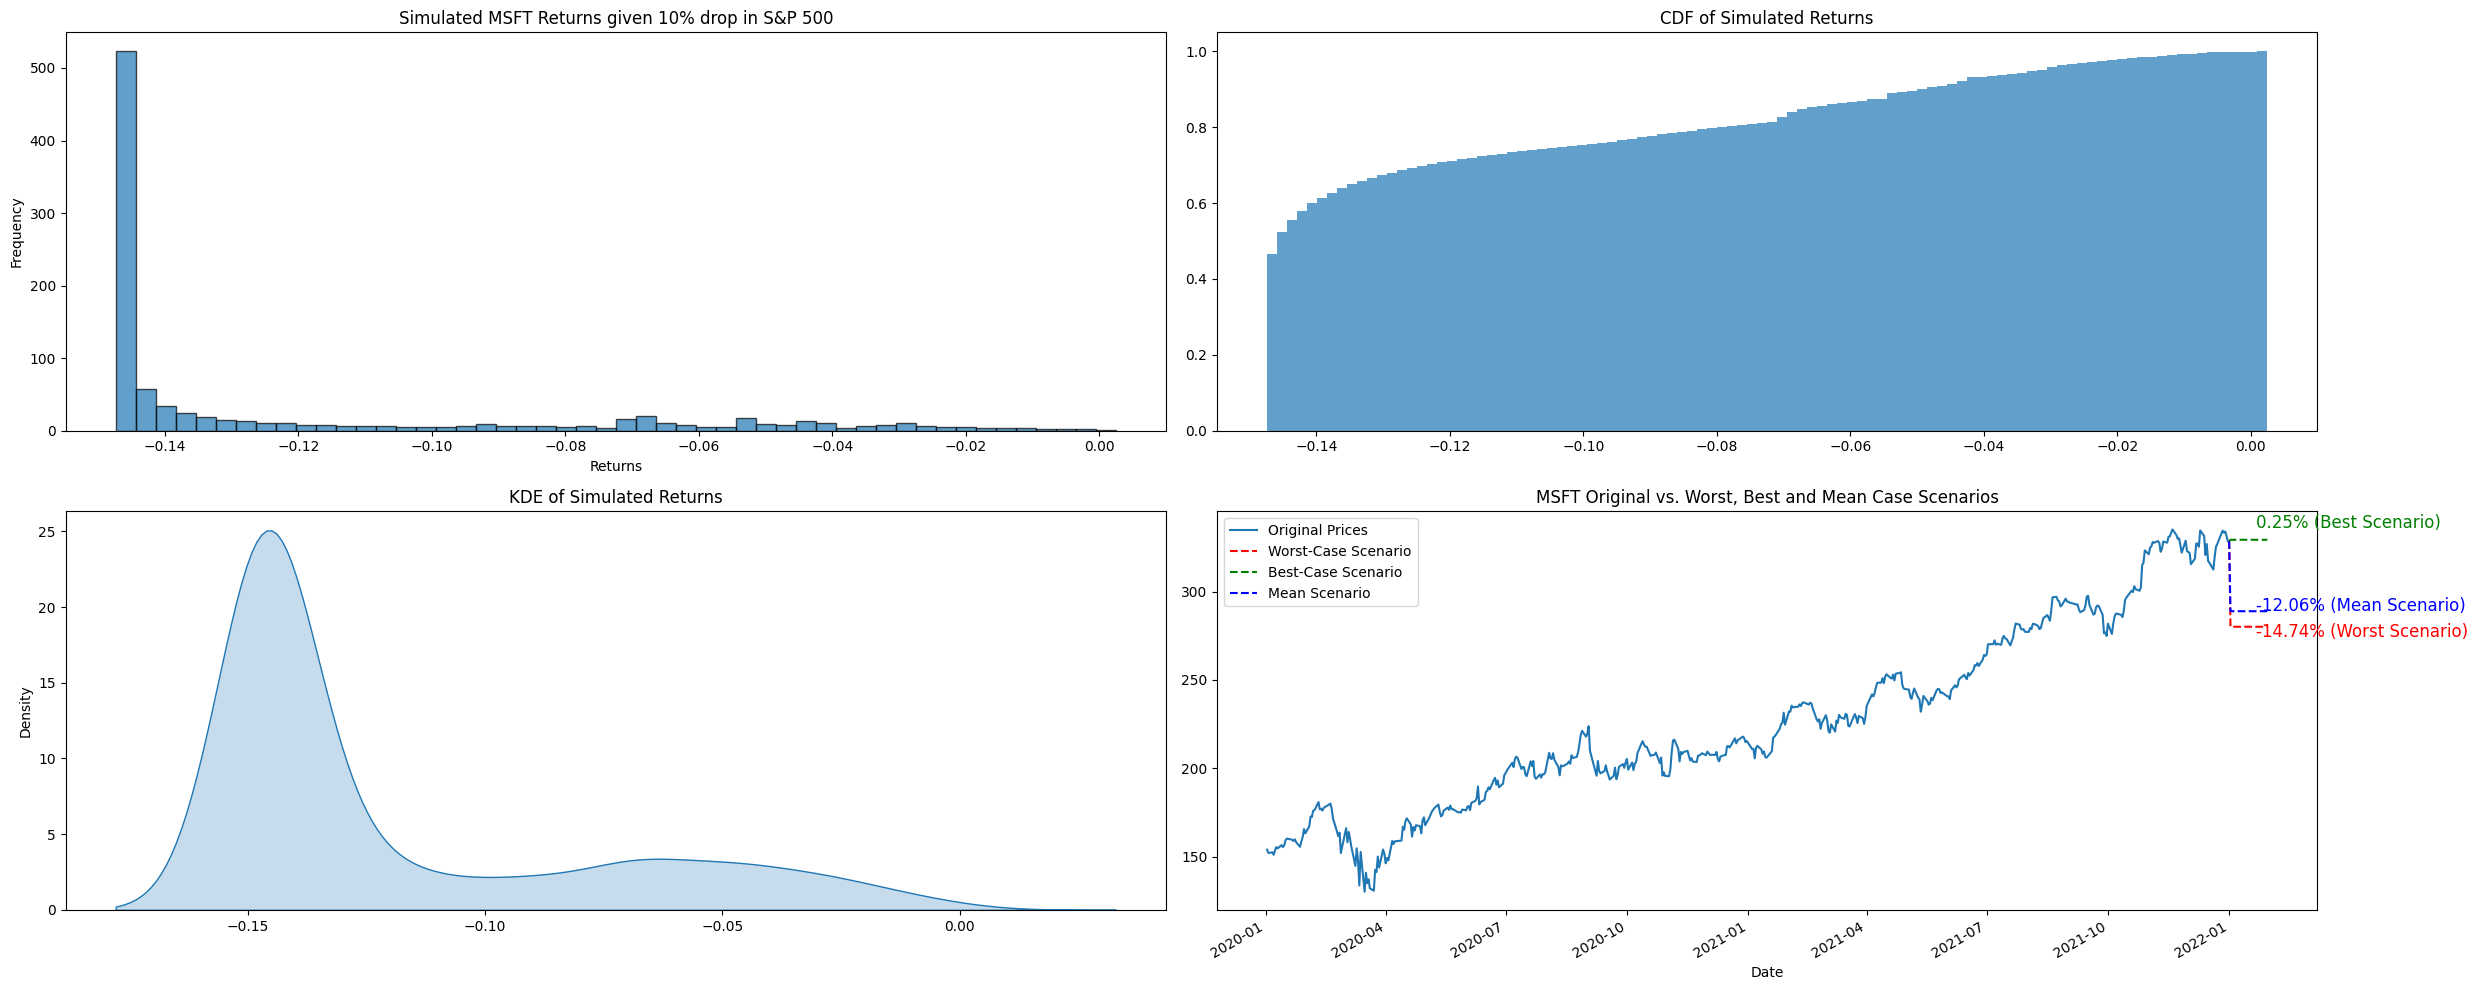

<ipython-input-6-bee365d4d98b>:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(conditional_returns, shade=True, ax=ax[1, 0])


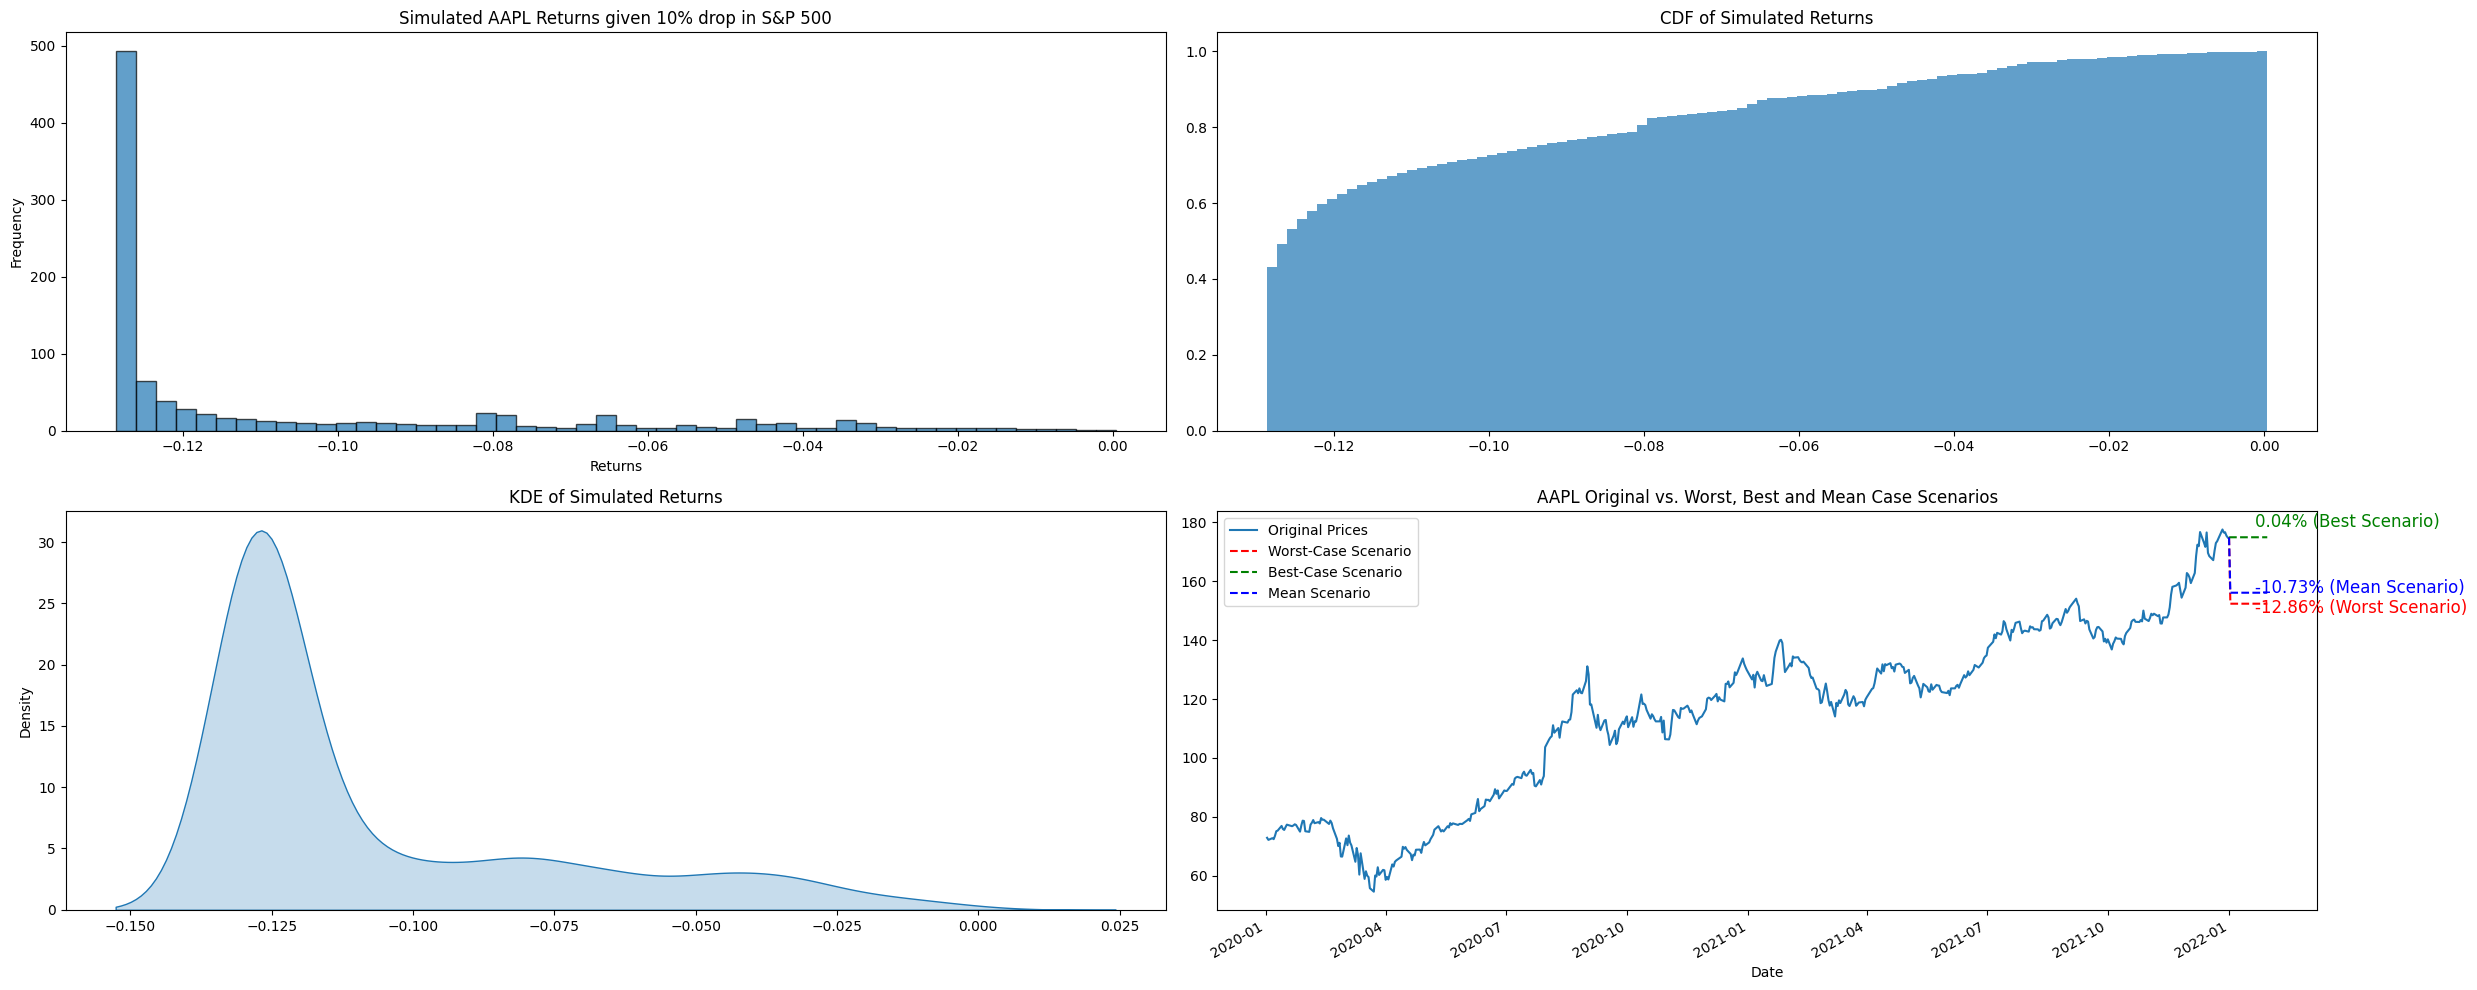

<ipython-input-6-bee365d4d98b>:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(conditional_returns, shade=True, ax=ax[1, 0])


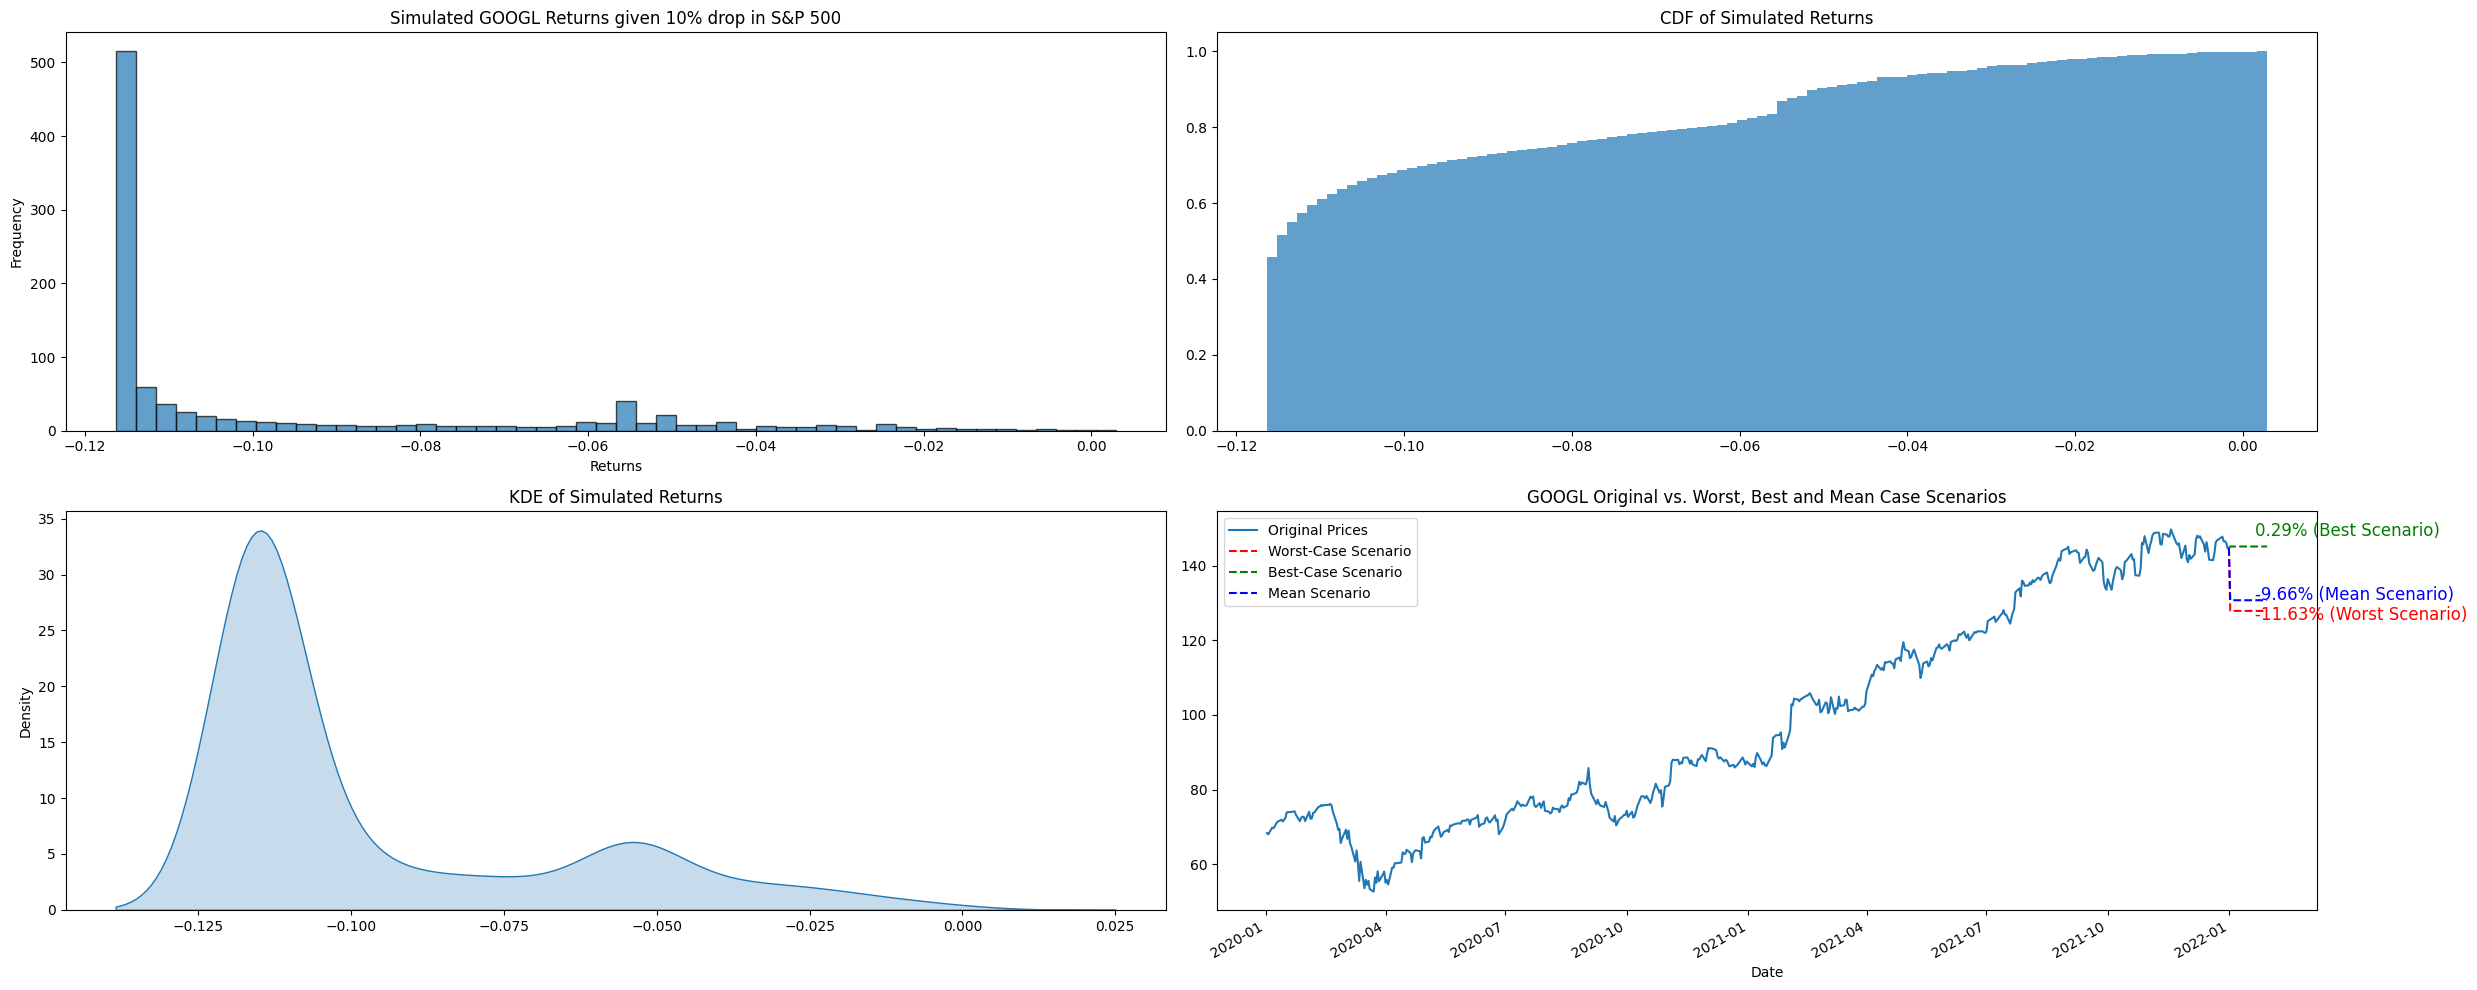

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for ticker, conditional_returns in results.items():
    """Visualization for each stock in the portfolio"""
    fig, ax = plt.subplots(2, 2, figsize=(25, 10))
    last_known_price = data[ticker].iloc[-1]
    min_return = np.min(conditional_returns)
    max_return = np.max(conditional_returns)
    mean_return = np.mean(conditional_returns)

    final_min_price = last_known_price * (1 + min_return)
    final_max_price = last_known_price * (1 + max_return)
    final_mean_price = last_known_price * (1 + mean_return)

    simulated_dates = pd.date_range(start=data.index[-1], periods=31, freq='D')[1:]

    min_price_trajectory = [last_known_price] + [final_min_price] * (len(simulated_dates) - 1)
    max_price_trajectory = [last_known_price] + [final_max_price] * (len(simulated_dates) - 1)
    mean_price_trajectory = [last_known_price] + [final_mean_price] * (len(simulated_dates) - 1)

    # Plot 1: Histogram of Simulated Returns
    ax[0, 0].hist(conditional_returns, bins=50, edgecolor='k', alpha=0.7)
    ax[0, 0].set_title(f"Simulated {ticker} Returns given 10% drop in S&P 500")
    ax[0, 0].set_xlabel("Returns")
    ax[0, 0].set_ylabel("Frequency")

    # Plot 2: CDF of Simulated Returns
    ax[0, 1].hist(conditional_returns, bins=100, density=True, cumulative=True, alpha=0.7)
    ax[0, 1].set_title('CDF of Simulated Returns')

    # Plot 3: KDE of Simulated Returns
    sns.kdeplot(conditional_returns, shade=True, ax=ax[1, 0])
    ax[1, 0].set_title('KDE of Simulated Returns')

    # Plot 4: Ticker Original vs. Worst, Best, and Mean Case Scenarios
    data[ticker].plot(ax=ax[1, 1], label="Original Prices")
    pd.Series(min_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Worst-Case Scenario", linestyle='--', color="red")
    pd.Series(max_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Best-Case Scenario", linestyle='--', color="green")
    pd.Series(mean_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Mean Scenario", linestyle='--', color="blue")

    label_x_position = simulated_dates[-10]
    ax[1, 1].annotate(f"{min_return*100:.2f}% (Worst Scenario)", (label_x_position, final_min_price * 0.98), fontsize=12, ha="left", color="red")
    ax[1, 1].annotate(f"{max_return*100:.2f}% (Best Scenario)", (label_x_position, final_max_price * 1.02), fontsize=12, ha="left", color="green")
    ax[1, 1].annotate(f"{mean_return*100:.2f}% (Mean Scenario)", (label_x_position, final_mean_price), fontsize=12, ha="left", color="blue")

    ax[1, 1].set_title(f"{ticker} Original vs. Worst, Best and Mean Case Scenarios")
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()

Visualization for the portfolio.

<ipython-input-7-13bb0663e7fa>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(portfolio_returns, shade=True, ax=ax[1, 0])


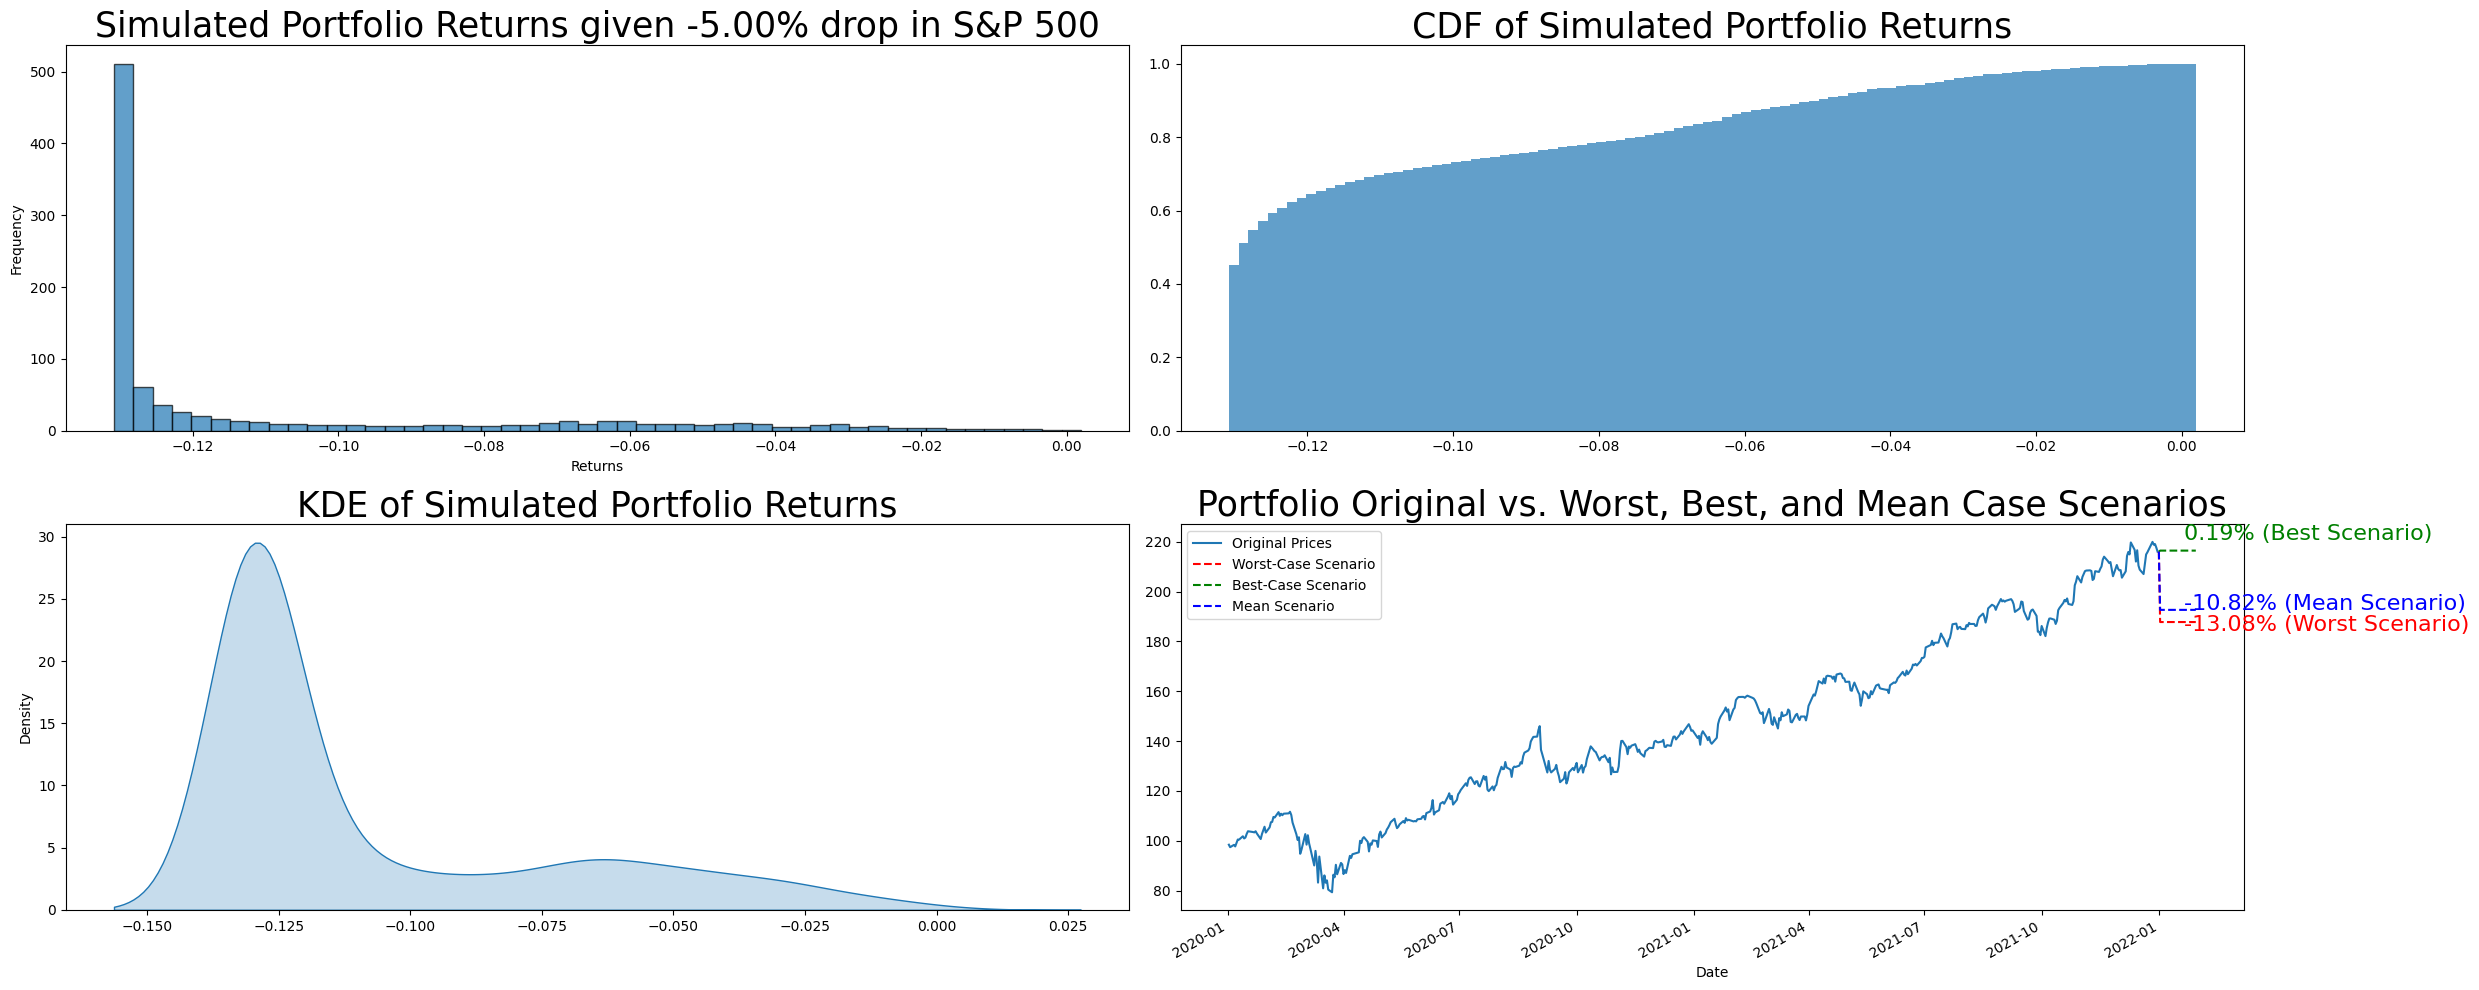

In [ ]:
# Compute portfolio returns from individual stock returns
portfolio_returns = np.mean(np.array([results[ticker] for ticker in portfolio_tickers]), axis=0)

# Visualization for the Portfolio
fig, ax = plt.subplots(2, 2, figsize=(25, 10))
last_known_prices = data[portfolio_tickers].iloc[-1]
portfolio_last_known_price = np.mean(last_known_prices)  # Equally weighted

min_return = np.min(portfolio_returns)
max_return = np.max(portfolio_returns)
mean_return = np.mean(portfolio_returns)

final_min_price = portfolio_last_known_price * (1 + min_return)
final_max_price = portfolio_last_known_price * (1 + max_return)
final_mean_price = portfolio_last_known_price * (1 + mean_return)

simulated_dates = pd.date_range(start=data.index[-1], periods=31, freq='D')[1:]

min_price_trajectory = [portfolio_last_known_price] + [final_min_price] * (len(simulated_dates) - 1)
max_price_trajectory = [portfolio_last_known_price] + [final_max_price] * (len(simulated_dates) - 1)
mean_price_trajectory = [portfolio_last_known_price] + [final_mean_price] * (len(simulated_dates) - 1)

# Plot 1: Histogram of Simulated Returns
ax[0, 0].hist(portfolio_returns, bins=50, edgecolor='k', alpha=0.7)
ax[0, 0].set_title(f"Simulated Portfolio Returns given {market_drop_percentage*100:.2f}% drop in S&P 500", fontsize=25)
ax[0, 0].set_xlabel("Returns")
ax[0, 0].set_ylabel("Frequency")

# Plot 2: CDF of Simulated Returns
ax[0, 1].hist(portfolio_returns, bins=100, density=True, cumulative=True, alpha=0.7)
ax[0, 1].set_title('CDF of Simulated Portfolio Returns', fontsize=25)

# Plot 3: KDE of Simulated Returns
sns.kdeplot(portfolio_returns, shade=True, ax=ax[1, 0])
ax[1, 0].set_title('KDE of Simulated Portfolio Returns', fontsize=25)

# Plot 4: Portfolio Original vs. Worst, Best, and Mean Case Scenarios
portfolio_prices = data[portfolio_tickers].mean(axis=1)
portfolio_prices.plot(ax=ax[1, 1], label="Original Prices")
pd.Series(min_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Worst-Case Scenario", linestyle='--', color="red")
pd.Series(max_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Best-Case Scenario", linestyle='--', color="green")
pd.Series(mean_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Mean Scenario", linestyle='--', color="blue")

label_x_position = simulated_dates[-10]
ax[1, 1].annotate(f"{min_return*100:.2f}% (Worst Scenario)", (label_x_position, final_min_price * 0.98), fontsize=16, ha="left", color="red")
ax[1, 1].annotate(f"{max_return*100:.2f}% (Best Scenario)", (label_x_position, final_max_price * 1.02), fontsize=16, ha="left", color="green")
ax[1, 1].annotate(f"{mean_return*100:.2f}% (Mean Scenario)", (label_x_position, final_mean_price), fontsize=16, ha="left", color="blue")

ax[1, 1].set_title(f"Portfolio Original vs. Worst, Best, and Mean Case Scenarios", fontsize=25)
ax[1, 1].legend()

# General configurations for the plot aesthetics
sns.set_style("whitegrid")
plt.tight_layout()
plt.show()

Some observations on the plots.
1.   **Histograms**: This showcases the distribution of the potential portfolio returns after the market shock. It allows the analyst to quickly identify the range and frequency of these returns.
2.   **Comulative Distribution Function**: This provides a cumulative perspective on the returns, helping identify the probability that the returns will fall within a certain range. For instance, if one wanted to see the worst 10% of outcomes, they’d look at the 10th percentile on the CDF.
3.   **Kernel Density Estimation (KDE)**: A smoothed version of the histogram, this offers a clearer view of the distribution’s shape, helping highlight modes and other features that might not be as apparent in a histogram.
4.  **Comparative Trajectory**: This plots the forecasted portfolio value trajectory over a specified period, comparing the original trajectory with potential best-case, worst-case, and mean scenarios after the shock.

$\clubsuit$-2 **Exercise:** Tail Dependence with Copulas.

Scenario analysis allowed us to perceive the potential impacts of various hypothetical market events. However, to comprehend the **systemic risk** associated with our portfolio, we must look beyond individual stock behaviors and evaluate their joint behavior, especially during extreme market conditions.
Implement a code that does the following steps:
1.   **Data Preprocessing**: write a function that convert the returns data to a uniform distribution using the empirical cumulative distribution function (ECDF).
2.   **Rolling Time Window Analysis:** Perform a rolling window analysis on the data with a window size of 250 days. Within each window, fit a **Clayton copula** to the data to capture the dependence structure between the assets. In particular, extract the tail dependence parameter for each time window; plot the time-series of the tail dependence parameter and construct a heatmap with the obtained tail dependence matrix.